![Machine Learning Lab](banner.jpg)

# Laboratorio 2

## Objetivos

1. Preparación de datos: Descargar, cargar y preprocesar datasets sobre depresión en estudiantes y precios de laptops, incluyendo imputación de valores faltantes, normalización y codificación de variables.

2. Modelado y evaluación.

3. Entrenar y evaluar un modelo de regresión logística para predecir depresión en estudiantes.

4. Entrenar y evaluar un modelo de regresión lineal para predecir precios de laptops.

5. Análisis de overfitting: Identificar overfitting mediante curvas de aprendizaje y comparar el rendimiento en entrenamiento y validación.

6. Regularización: Aplicar técnicas de regularización (L1, L2, Elastic Net) en regresión lineal (Ridge, Lasso) y logística para reducir overfitting.

7. Optimización de modelos: Usar Grid Search con validación cruzada para encontrar los mejores hiperparámetros y evaluar el modelo optimizado.

## Descarga de datasets

Antes de comenzar, descarguemos los datasets necesarios para el laboratorio. Estos datasets incluyen información sobre depresión en estudiantes y precios de laptops.

In [1]:
!mkdir datasets

In [2]:
!curl -L -o datasets/student-depression-dataset.zip https://www.kaggle.com/api/v1/datasets/download/hopesb/student-depression-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  453k  100  453k    0     0   544k      0 --:--:-- --:--:-- --:--:-- 3857k


In [3]:
!unzip datasets/student-depression-dataset.zip -d datasets/student-depression-dataset

Archive:  datasets/student-depression-dataset.zip
  inflating: datasets/student-depression-dataset/Student Depression Dataset.csv  


In [4]:
!curl -L -o datasets/laptop-price-dataset.zip https://www.kaggle.com/api/v1/datasets/download/muhammetvarl/laptop-price

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 28633  100 28633    0     0  49344      0 --:--:-- --:--:-- --:--:-- 49344


In [5]:
!unzip datasets/laptop-price-dataset.zip -d datasets/laptop-price-dataset

Archive:  datasets/laptop-price-dataset.zip
  inflating: datasets/laptop-price-dataset/laptop_price.csv  


## Cargar librerias

Importamos las librerías necesarias para el análisis de datos, preprocesamiento, modelado y evaluación.

In [6]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

## Load Data

Cargamos los datasets descargados y revisamos su estructura y contenido.

In [7]:
depression_df = pd.read_csv('datasets/student-depression-dataset/Student Depression Dataset.csv')
laptop_price_df = pd.read_csv('datasets/laptop-price-dataset/laptop_price.csv', encoding='iso-8859-1')

In [8]:
depression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [9]:
laptop_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


## 1. Modelos Base sin Regularización

### 1.1 Preparación de Datos - Regresión Logística (Depresión)

Preparamos los datos para el modelo de regresión logística que predecirá la depresión en estudiantes. Esto incluye la imputación de valores faltantes, la división de datos en conjuntos de entrenamiento y prueba, y la normalización y codificación de variables.

In [10]:
numeric_features = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction',
    'Work/Study Hours', 'Financial Stress'
]

cat_columns = [
    'Gender', 'Dietary Habits',
    'Family History of Mental Illness',
    'Have you ever had suicidal thoughts ?'
]

# Dividir datos
X_dep = depression_df[numeric_features + cat_columns]
y_dep = depression_df['Depression']

X_dep_train, X_dep_test, y_dep_train, y_dep_test = train_test_split(
    X_dep, y_dep, test_size=0.2, random_state=22
)

# Pipeline para imputar y escalar valores numéricos
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para imputar y codificar valores categóricos
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, cat_columns)
    ]
)

X_dep_train_prepared = preprocessor.fit_transform(X_dep_train)
X_dep_test_prepared = preprocessor.transform(X_dep_test)

### 1.2 Regresión Logística Base

Entrenamos un modelo de regresión logística sin regularización y evaluamos su rendimiento en los conjuntos de entrenamiento y prueba.

In [11]:
# Entrenar modelo
log_reg = LogisticRegression(random_state=22)
log_reg.fit(X_dep_train_prepared, y_dep_train)

# Evaluar modelo
y_pred_train_log = log_reg.predict(X_dep_train_prepared)
y_pred_test_log = log_reg.predict(X_dep_test_prepared)

# Métricas
print("Métricas Regresión Logística:")
print("\nEntrenamiento:")
print(classification_report(y_dep_train, y_pred_train_log,
                            target_names=['No Depression', 'Depression'],
                            digits=3))

print("\nTest:")
print(classification_report(y_dep_test, y_pred_test_log,
                            target_names=['No Depression', 'Depression'],
                            digits=3))

Métricas Regresión Logística:

Entrenamiento:
               precision    recall  f1-score   support

No Depression      0.829     0.790     0.809      9215
   Depression      0.857     0.886     0.871     13105

     accuracy                          0.846     22320
    macro avg      0.843     0.838     0.840     22320
 weighted avg      0.846     0.846     0.845     22320


Test:
               precision    recall  f1-score   support

No Depression      0.827     0.794     0.810      2350
   Depression      0.854     0.880     0.867      3231

     accuracy                          0.844      5581
    macro avg      0.841     0.837     0.839      5581
 weighted avg      0.843     0.844     0.843      5581



### 1.3 Preparación de Datos - Regresión Lineal (Precios de Laptops)

Preparamos los datos para el modelo de regresión lineal que predecirá los precios de las laptops. Similar al anterior, se imputan valores faltantes, se dividen los datos y se normalizan y codifican las variables.

In [13]:
cat_columns = laptop_price_df.select_dtypes(include=['object']).columns.tolist()
numeric_features = laptop_price_df.drop(columns=['Price_euros']).select_dtypes(include=['number']).columns.tolist()

# Dividir datos
X_car = laptop_price_df[numeric_features + cat_columns]
y_car = laptop_price_df['Price_euros']
X_laptop_train, X_laptop_test, y_laptop_train, y_laptop_test = train_test_split(X_car, y_car, test_size=0.2, random_state=22)

# Pipeline para imputar y escalar valores numéricos
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para imputar y codificar valores categóricos
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    # handle_unknown='ignore' es necesario si en test aparecen categorias que no estaban en train
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, cat_columns)
    ])

X_laptop_train_prepared = preprocessor.fit_transform(X_laptop_train)
X_laptop_test_prepared = preprocessor.transform(X_laptop_test)

### 1.4 Regresión Lineal Base

Entrenamos un modelo de regresión lineal sin regularización y evaluamos su rendimiento en los conjuntos de entrenamiento y prueba.

In [14]:
# Entrenar modelo
lin_reg = LinearRegression()
lin_reg.fit(X_laptop_train_prepared, y_laptop_train)

# Evaluar modelo
y_pred_train_lin = lin_reg.predict(X_laptop_train_prepared)
y_pred_test_lin = lin_reg.predict(X_laptop_test_prepared)

# Métricas
print("\nMétricas Regresión Lineal:")
print("\nEntrenamiento:")
print(f"MSE: {mean_squared_error(y_laptop_train, y_pred_train_lin):.2f}")
print(f"R2: {r2_score(y_laptop_train, y_pred_train_lin):.3f}")

print("\nTest:")
print(f"MSE: {mean_squared_error(y_laptop_test, y_pred_test_lin):.2f}")
print(f"R2: {r2_score(y_laptop_test, y_pred_test_lin):.3f}")


Métricas Regresión Lineal:

Entrenamiento:
MSE: 4441.27
R2: 0.991

Test:
MSE: 165693.53
R2: 0.680


### 1.5 Overfitting

En todos los modelos siempre existe una diferencia entre la calidad de las predicciones en el set de entrenamiento y el set de validación/testing. Esta diferencia se conoce como varianza. Una excesiva varianza se conoce como overfitting.

Para entender mejor esto vamos a hacer una gráfica comparando la pérdida entre train y test con distintos tamaños del dataset de entrenamiento


In [15]:

def linear_regression_learning_curve(model, X, y, plot=True):
    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),  # Porcentajes del dataset de entrenamiento
        cv=5,  # Validación cruzada de 5 folds
        scoring='neg_mean_squared_error',  # Métrica de evaluación (error cuadrático medio negativo)
        n_jobs=-1  # Usar todos los núcleos disponibles
    )

    # Calcular la media y desviación estándar de los scores
    train_scores_mean = -np.mean(train_scores, axis=1)  # Convertir a positivo
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)  # Convertir a positivo
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        # Graficar las curvas de aprendizaje
        plt.figure(figsize=(10, 6))

        # Plot training error
        sns.lineplot(x=train_sizes, y=train_scores_mean, label='Training error', color='blue', marker='o')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.15, color='blue')

        # Plot validation error
        sns.lineplot(x=train_sizes, y=test_scores_mean, label='Validation error', color='green', marker='o')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.15, color='green')

        # Add titles and labels
        plt.title('Learning Curves for Linear Regression', fontsize=16)
        plt.xlabel('Training Set Size', fontsize=14)
        plt.ylabel('Mean Squared Error', fontsize=14)
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    # tomamos la comparacion de un dataset de entrenamiento del 70%
    print('Training score (MSE):', train_scores_mean[-3])
    print('Test score (MSE):', test_scores_mean[-3])
    print('Percent difference, train vs test:', (train_scores_mean[-3] - test_scores_mean[-3]) / test_scores_mean[-3] * 100, '%')

/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - 

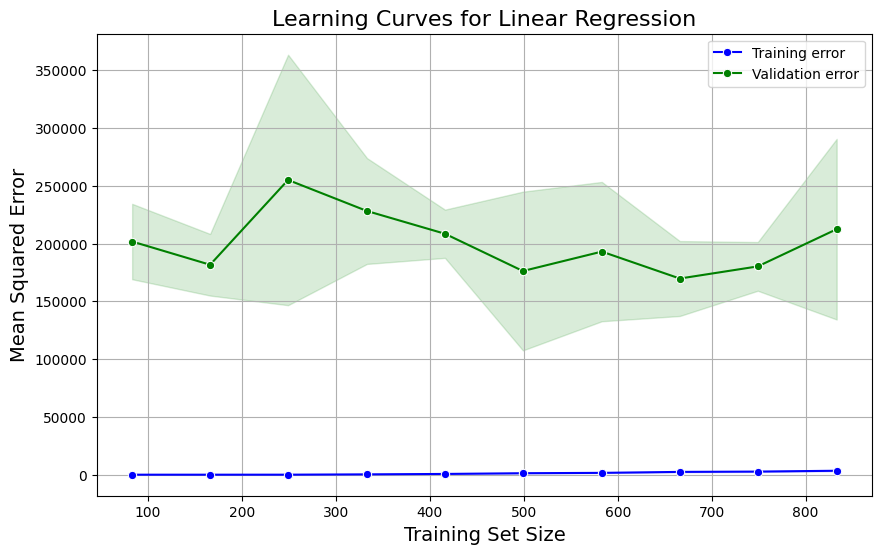

Training score (MSE): 2415.7829559681513
Test score (MSE): 169730.13865660172
Percent difference, train vs test: -98.5766918149665 %


In [16]:
linear_regression_learning_curve(LinearRegression(), X_laptop_train_prepared, y_laptop_train)

### Regularización en regresión lineal

Como podemos ver en los resultados anteriores la diferencia entre train y validación puede ser amplia.

Para resolver esto tenemos estrategias como la regularización esto consiste en penalizar la complejidad del modelo mediante:
- `l1` en este caso se penaliza la suma del valor absoluto los parámetros del modelo
- `l2` penaliza la suma de los cuadrados de los parámetros de los modelos
- `elasticnet` penaliza una combinación lineal de `l1` y `l2`.

Cuando una regresión lineal usa `l2` se le conoce como regresión Ridge mientras que cuando usa `l1` se le conoce como regresión Lasso

En ambos casos se necesita de un hyper-parámetro alpha para determinar cuánta importancia se le da al MSE y cuánta importancia se le da al MSE

`LOSS = MSE + alpha * regularization`

/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - 

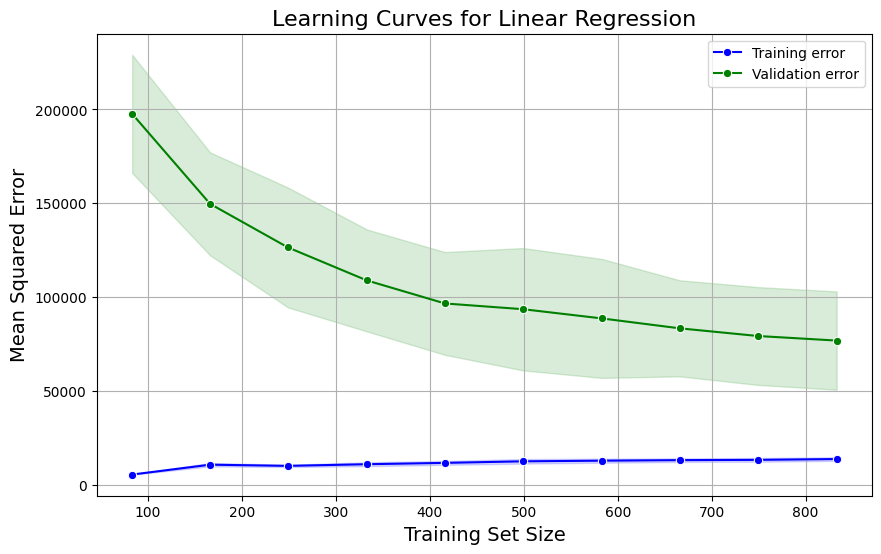

Training score (MSE): 13041.289545959324
Test score (MSE): 83305.25314288167
Percent difference, train vs test: -84.34517746006792 %


In [17]:
linear_regression_learning_curve(Ridge(alpha=1.0), X_laptop_train_prepared, y_laptop_train, plot=True)

/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - 

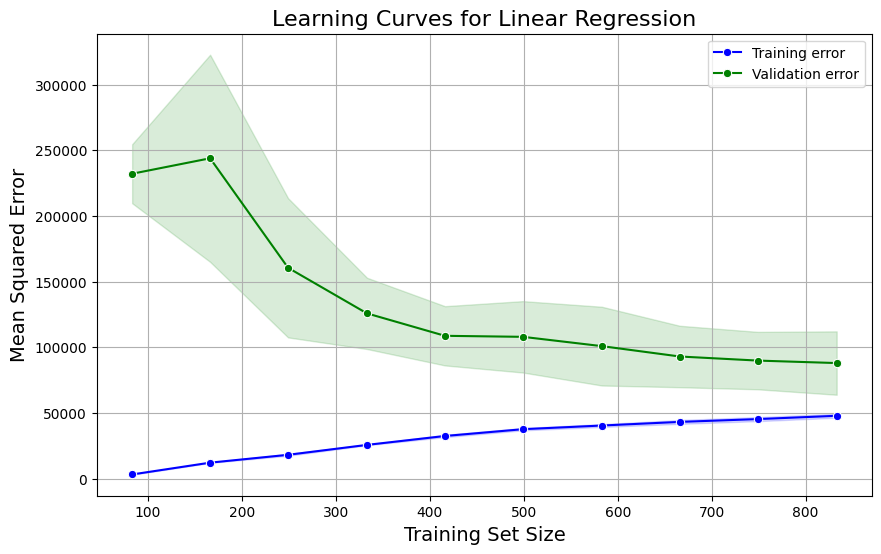

Training score (MSE): 43159.085839841086
Test score (MSE): 92979.69243164081
Percent difference, train vs test: -53.58224499229024 %


In [18]:
linear_regression_learning_curve(Lasso(alpha=1.0), X_laptop_train_prepared, y_laptop_train, plot=True)


Aquí vemos como la varianza al usar una regresión Lasso es menor que cuando usamos una regresión lineal tradicional.

### Regularización en regresión logística

En el caso de la regresión logística los mismos argumentos se aplican. Podemos usar regularización para reducir el Overfitting.


In [19]:
def logistic_learning_curve(model, X, y, plot=True):
    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),  # Porcentajes del dataset de entrenamiento
        cv=5,  # Validación cruzada de 5 folds
        scoring='f1',  # Métrica de evaluación
        n_jobs=-1  # Usar todos los núcleos disponibles
    )


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    if plot:
        # Graficar las curvas de aprendizaje
        plt.figure(figsize=(10, 6))

        # Plot training score
        sns.lineplot(x=train_sizes, y=train_scores_mean, label='Training score', color='blue', marker='o')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.15, color='blue')

        # Plot validation score
        sns.lineplot(x=train_sizes, y=test_scores_mean, label='Validation score', color='green', marker='o')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.15, color='green')

        # Add titles and labels
        plt.title(f'Learning Curves for Logistic Regression (F1)', fontsize=16)
        plt.xlabel('Training Set Size', fontsize=14)
        plt.ylabel('F1', fontsize=14)
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    n=4

    print(f'Training score (F1):', train_scores_mean[-n])
    print(f'Test score (F1):', test_scores_mean[-n])
    print('Percent difference, train vs test:', - (train_scores_mean[-n] - test_scores_mean[-n]) / test_scores_mean[-n] * 100, '%')

/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered i

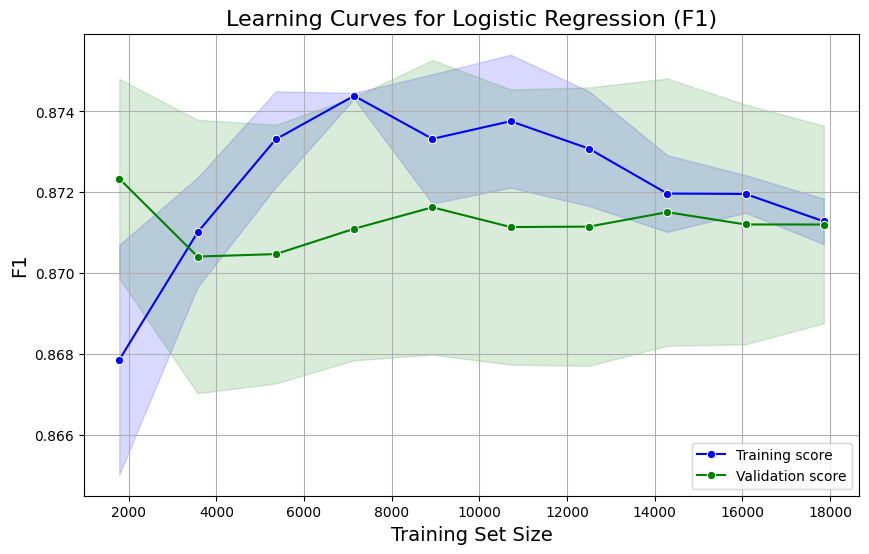

Training score (F1): 0.8730799738902422
Test score (F1): 0.8711542938792143
Percent difference, train vs test: -0.22104924748208632 %


In [20]:
# Por defecto sklearn regulariza las regresiones logisticas usando `l2` por eso para ver los resultados sin regularizacion debemos usar penalty=None
logistic_learning_curve(LogisticRegression(penalty=None), X_dep_train_prepared, y_dep_train)

In [21]:
logistic_learning_curve(LogisticRegression(penalty='l2', C=1.0), X_dep_train_prepared, y_dep_train, plot=False)

Training score (F1): 0.8730983855805269
Test score (F1): 0.8711965677074115
Percent difference, train vs test: -0.2182995139799615 %


/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWar

### Grid search y Selección de modelo

Estas estrategias han sido útiles, pero ahora hemos introducido un nuevo problema. Cómo escogemos qué hyper-parámetros usar. Qué tipo de regularización usar? ¿Debemos probar todas estas combinaciones a mano?

No. Sklearn nos provee con una herramienta para hacer la búsqueda del mejor modelo sobre los hyperparameters. Esta es `Grid Search CV`, pero para esto necesitamos una métrica para comparar los modelos. Esta no tiene por qué ser la perdida del modelo. En nuestro caso escogeremos el f1 score, ya que balancea la sensibilidad y especificidad del modelo.


In [22]:


# Grid de parámetros
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Inicializar el modelo de regresión logística
log_reg = LogisticRegression(solver='saga', max_iter=10000)

# Hacer la búsqueda
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_dep_train_prepared, y_dep_train)

# Obtener el mejor modelo y parámetros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_dep_test_prepared)
accuracy = accuracy_score(y_dep_test, y_pred)
print("Test Set Accuracy:", accuracy)

Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Test Set Accuracy: 0.8437555993549543
